## Forest- Small

In [92]:
# Begin by importing libraries
import gym
from hiive.mdptoolbox.mdp import PolicyIteration, ValueIteration, QLearning

import numpy as np
import pandas as pd
import seaborn as sns
import time

import hiive.mdptoolbox as mdptoolbox
import hiive.mdptoolbox.example

np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [93]:
# code based on https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def generate_score(env, policy, print_info=False, eps=1000):
    misses, spts_lst = 0, []
    for ep in range(eps):
        obs, steps = env.reset(), 0
        while True:
            action = policy[obs]
            obs, reward, complete, _ = env.step(action)
            steps = steps+1
            if reward == 1 and complete:
                spts_lst.append(steps)
                break
            elif reward == 0 and complete:
                misses = misses+ 1
                break
    ave_steps, std_steps = np.mean(spts_lst), np.std(spts_lst)
    pctt_fail  = (misses/eps)* 100

    return ave_steps, std_steps, pctt_fail

In [94]:
colors, labels = {0: 'green',1: 'k'}, {0: 'W',1: 'C'}

def plot_forest_mdp(policy, title='Forest Management'):
    rows,cols = 10,10
    policy = np.array(list(policy)).reshape(rows,cols)
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, xlim=(-.01, cols+0.01), ylim = (-.01, rows+0.01))
    plt.title(title, fontsize=14, weight='bold', y=1.01)
    
    for i in range(10):
        for j in range(10):
            y, x = 10 - i - 1, j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[policy[i,j]])
            ax.add_patch(p)
            
            text = ax.text(x+0.5, y+0.5, labels[policy[i, j]],
                           horizontalalignment='center', size=10, verticalalignment='center', color='w')

In [95]:
T,R = hiive.mdptoolbox.example.forest(S=100)

# VI

In [96]:
def value_iteration(t, r, gammas, epsilons, show_results=False, max_iterations=100000):
    time_start = time.time()

    df = pd.DataFrame(0.0, index=np.arange(len(epsilons)*len(gammas)), columns=['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error'])

    test_num = 0
    for g in gammas:
        for e in epsilons:
            test = ValueIteration(t, r, gamma=g, epsilon=e, max_iter=max_iterations)
            
            runs, Time  = test.run(), runs[-1]['Time']
            iters, maxR = runs[-1]['Iteration'], runs[-1]['Max V']
            
            max_rewards, mean_rewards, errors = [], [], []
            for run in runs:
                max_rewards.append(run['Max V'])
                mean_rewards.append(run['Mean V'])
                errors.append(run['Error'])
            
            policy = np.array(test.policy)
            
            df['gamma'][test_num], df['epsilon'][test_num]       = g, e
            df['time'][test_num], df['iterations'][test_num]         = Time, iters
            df['reward'][test_num], df['mean_rewards'][test_num]       = maxR, {tuple(mean_rewards)}
            df['max_rewards'][test_num], df['error'][test_num]  = {tuple(max_rewards)}, np.mean(errors)
            df['policy'][test_num]       = {test.policy}
                        
            test_num += 1
        
    endTime = time.time() - time_start
    policies = df['policy']
    
    df = df.fillna(0)        
    return df

In [ ]:
epsilons = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-8, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14]
gammas   = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999]
vi_res  = value_iteration(T, R, gammas, epsilons, show_results=False)

In [98]:
policies = vi_res['policy']

## Policy

Best Result:
	Reward = 185.16
	Gamma = 0.9990000
	Epsilon= 1E-14


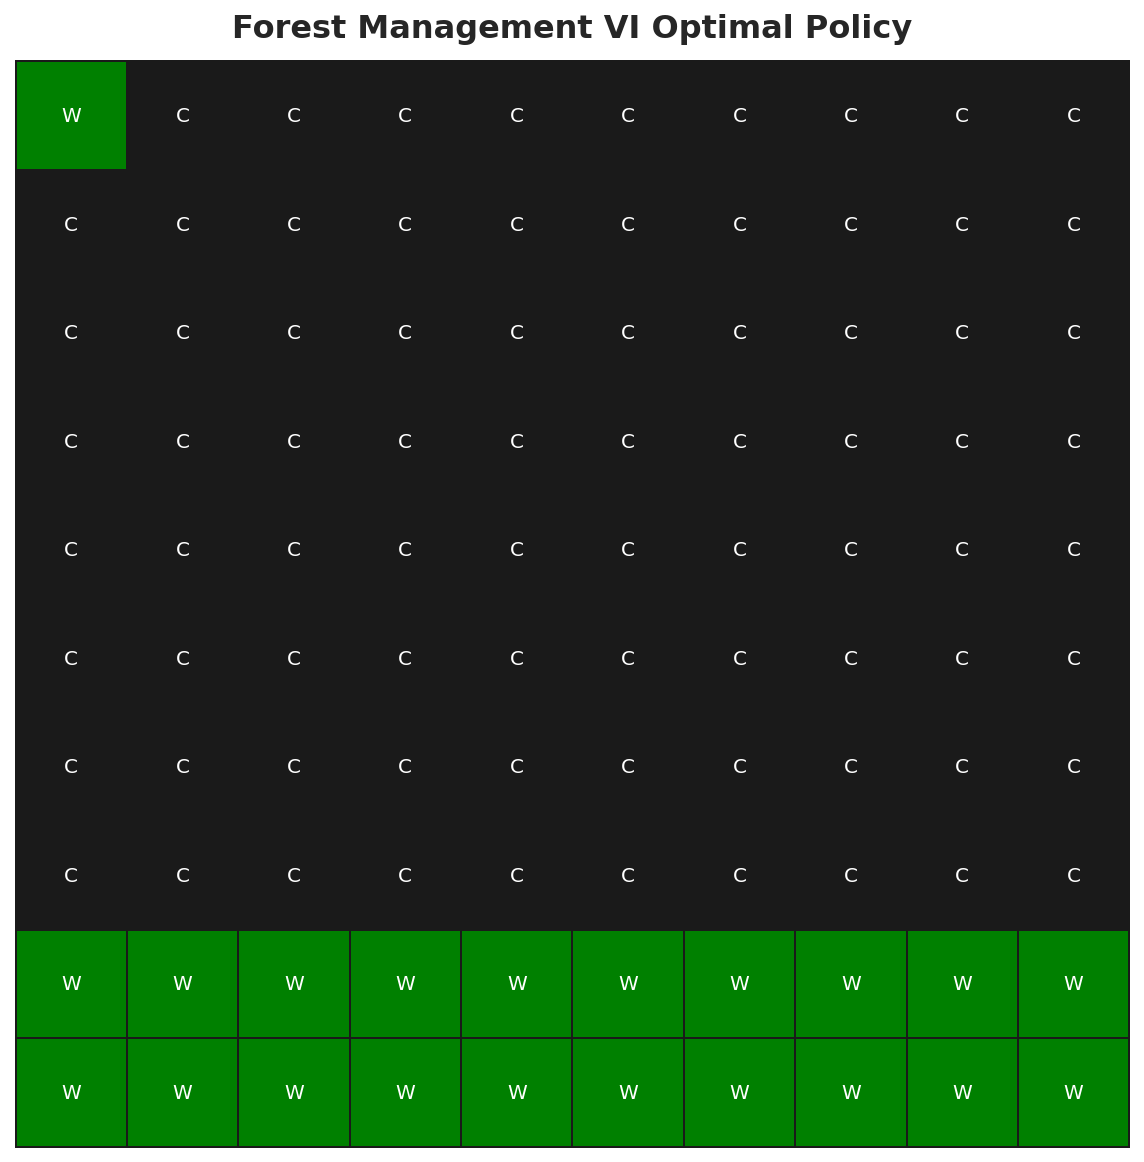

In [100]:
best_run = vi_res['reward'].argmax()
best_policy = vi_res['policy'][best_run]
plot_forest_mdp(best_policy, 'Forest Management VI Optimal Policy')

### PI 

In [101]:
def policy_iteration(t, r, gammas, show_results=False, max_iterations=100000):
    start_time = time.time()
    df = pd.DataFrame(0.0, index=np.arange(len(gammas)), columns=['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error'])
 
    test_num = 0
    for g in gammas:
        test = PolicyIteration(t, r, gamma=g, max_iter=max_iterations, eval_type="matrix")
        
        runs, Time, iters, maxr  = test.run(), test.time, test.iter, runs[-1]['Max V']
                
        max_rewards, mean_rewards, errors = [], [], []
        for run in runs:
            errors.append(run['Error'])
            max_rewards.append(run['Max V'])
            mean_rewards.append(run['Mean V'])
        
        df['gamma'][test_num], df['time'][test_num]        = g, Time
        df['iterations'][test_num], df['reward'][test_num]    = iters, maxr
        df['mean_rewards'][test_num], df['max_rewards'][test_num] = {tuple(mean_rewards)}, {tuple(max_rewards)}
        df['error'][test_num], df['policy'][test_num]         = np.mean(errors), {test.policy}
        
        test_num = test_num + 1
        
    end_time = time.time() - start_time
    policies = df['policy']
        
    df = df.fillna(0)
        
    return df

In [102]:
pi_res  = policy_iteration(T, R, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999], show_results=False)

gamma,	time,	iter,	reward
________________________________________________________________________________
0.10,	0.00,	1,	4.396613
0.20,	0.00,	1,	4.882699
0.30,	0.00,	2,	5.491933
0.40,	0.00,	2,	6.277574
0.50,	0.00,	3,	7.329154
0.60,	0.00,	3,	8.809994
0.70,	0.01,	5,	11.054551
0.80,	0.01,	6,	14.883721
0.90,	0.02,	10,	23.172434
1.00,	0.03,	20,	508.385877
Time taken: 0.10


In [105]:
pi_res.head(2)

,gamma,epsilon,time,iterations,reward,average_steps,steps_stddev,success_pct,policy,mean_rewards,max_rewards,error
0,0.1,0.0,0.001757,1.0,4.396613,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{(1.0338743824982355,)}","{(4.396612561750176,)}",0.000000e+00
1,0.2,0.0,0.001343,1.0,4.882699,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{(1.0681066556428274,)}","{(4.882699462587847,)}",8.881784e-16


## Policy

Best Result:
	Reward = 508.39
	Gamma = 0.999


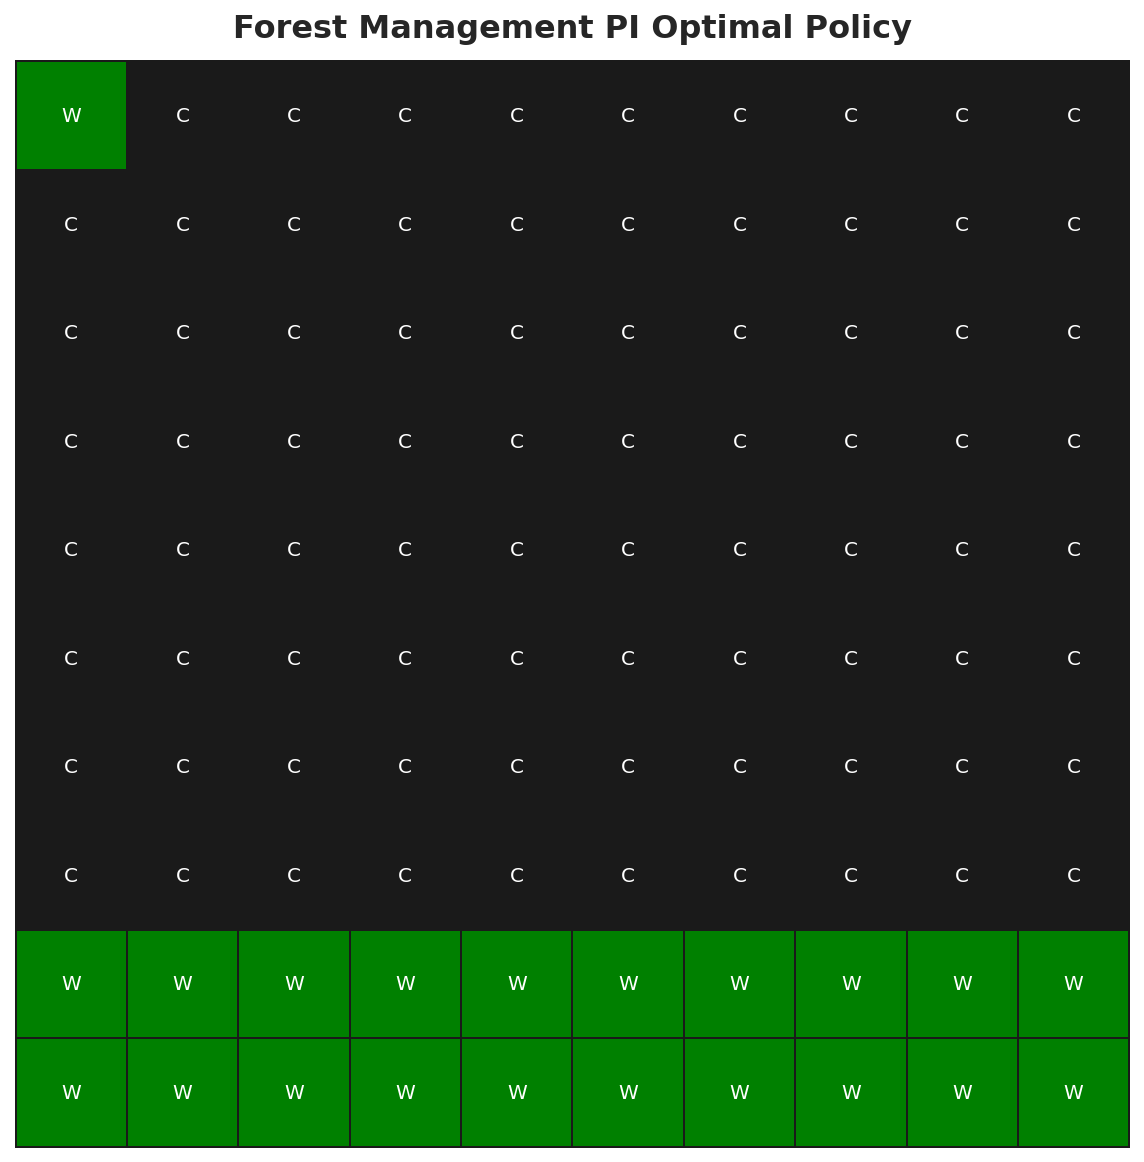

In [107]:
best_policy = pi_res['policy'][pi_res['reward'].argmax()]
plot_forest_mdp(best_policy, title='Forest Management PI Optimal Policy')

# QL

In [108]:
def q_learning(t, r, gammas, alphas, alpha_decays=[0.99], epsilon_decays=[0.99], n_iterations=[10000000], show_results=False):
    df = pd.DataFrame(0.0, index=np.arange(len(alphas)*len(gammas)*len(epsilon_decays)*len(alpha_decays)*len(n_iterations)), 
                      columns=['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'time', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error'])

    test_num = 0
    for g in gammas:
        for a in alphas:
            for a_decay in alpha_decays:
                for e_decay in epsilon_decays:
                    for n in n_iterations:

                        test = QLearning(t, r, gamma=g, alpha=a, alpha_decay=a_decay, epsilon_decay=e_decay, n_iter=n)
                        
                        runs, time  = test.run(),  runs[-1]['Time']
                        iters, maxR = runs[-1]['Iteration'], runs[-1]['Max V']                        
                        max_rewards, mean_rewards, errors = [], [], []
                        for run in runs:
                            max_rewards.append(run['Max V'])
                            errors.append(run['Error'])
                            mean_rewards.append(run['Mean V'])

                        df['gamma'][test_num], df['alpha'][test_num]         = g, a
                        df['alpha_decay'][test_num], df['epsilon_decay'][test_num]   = a_decay, e_decay
                        df['time'][test_num], df['iterations'][test_num]           = time, iters
                        df['reward'][test_num], df['mean_rewards'][test_num]        = maxR, {tuple(mean_rewards)}
                        df['max_rewards'][test_num], df['error'][test_num]   = {tuple(max_rewards)}, {tuple(errors)}
                        df['policy'][test_num]        = {test.policy}
                                                
                        if show_results:
                            pass
                        test_num += 1
            
    policies = df['policy']

    df = df.fillna(0)
    df.head()
        
    return df

In [45]:
alphas, gammas, alpha_decays, epsilon_decays  = [0.01, 0.1, 0.2], [0.8, 0.9, 0.99], [0.9, 0.999], [0.9, 0.999]
iterations = [10000, 20000]

ql_res  = q_learning(T, R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, show_results=False)

ql_res.head()

Gamma,	Alpha,	Time,	Iter,	Reward
________________________________________________________________________________
Test Num 1/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:10000
0.80,	0.01,	0.67,	10000,	1.686386
Test Num 2/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.900,	Iterations:20000
0.80,	0.01,	1.20,	20000,	2.274229
Test Num 3/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:10000
0.80,	0.01,	0.67,	10000,	1.634270
Test Num 4/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.900,	Epsilon Decay:0.999,	Iterations:20000
0.80,	0.01,	1.21,	20000,	2.252898
Test Num 5/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay:0.900,	Iterations:10000
0.80,	0.01,	0.66,	10000,	2.071719
Test Num 6/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay:0.900,	Iterations:20000
0.80,	0.01,	1.20,	20000,	2.429184
Test Num 7/72
Gamma: 0.80,	Alpha: 0.01,	Alpha Decay:0.999,	Epsilon Decay:0.999,	Iterations:10000
0.8

,gamma,alpha,alpha_decay,epsilon_decay,iterations,time,reward,average_steps,steps_stddev,success_pct,policy,mean_rewards,max_rewards,error
0,0.8,0.01,0.900,0.900,10000.0,0.666095,1.686386,0.0,0.0,0.0,"{(0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,...","{(0.0, 9e-05, 9e-05, 9e-05, 9e-05, 0.000149049...","{(0.0, 0.009000000000000001, 0.009000000000000...","{(0.0, 0.009000000000000001, 0.0, 0.0, 0.0, 0...."
1,0.8,0.01,0.900,0.900,20000.0,1.203518,2.274229,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","{(0.0, 8.147239200000001e-05, 0.00014724071620...","{(0.0, 0.008100000000000001, 0.014608103849112...","{(0.0, 4.723920000000002e-05, 6.87285711828217..."
2,0.8,0.01,0.900,0.999,10000.0,0.666800,1.634270,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 5.904900000000002e-...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.00590490000000000...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.00590490000000000..."
3,0.8,0.01,0.900,0.999,20000.0,1.208427,2.252898,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,...","{(9e-05, 9e-05, 9e-05, 9e-05, 0.00012874204890...","{(0.009000000000000001, 0.009000000000000001, ...","{(0.009000000000000001, 0.0, 0.0, 0.0, 0.00387..."
4,0.8,0.01,0.999,0.900,10000.0,0.657932,2.071719,0.0,0.0,0.0,"{(0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.9302096...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0099302...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0099302..."


In [46]:
ql_res = ql_res
ql_res.head()

,Unnamed: 0,gamma,alpha,alpha_decay,epsilon_decay,iterations,time,reward,average_steps,steps_stddev,success_pct,policy,mean_rewards,max_rewards,error
0,0,0.8,0.01,0.900,0.900,10000.0,0.666095,1.686386,0.0,0.0,0.0,"{(0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,...","{(0.0, 9e-05, 9e-05, 9e-05, 9e-05, 0.000149049...","{(0.0, 0.009000000000000001, 0.009000000000000...","{(0.0, 0.009000000000000001, 0.0, 0.0, 0.0, 0...."
1,1,0.8,0.01,0.900,0.900,20000.0,1.203518,2.274229,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,...","{(0.0, 8.147239200000001e-05, 0.00014724071620...","{(0.0, 0.008100000000000001, 0.014608103849112...","{(0.0, 4.723920000000002e-05, 6.87285711828217..."
2,2,0.8,0.01,0.900,0.999,10000.0,0.666800,1.634270,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 5.904900000000002e-...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.00590490000000000...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.00590490000000000..."
3,3,0.8,0.01,0.900,0.999,20000.0,1.208427,2.252898,0.0,0.0,0.0,"{(0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,...","{(9e-05, 9e-05, 9e-05, 9e-05, 0.00012874204890...","{(0.009000000000000001, 0.009000000000000001, ...","{(0.009000000000000001, 0.0, 0.0, 0.0, 0.00387..."
4,4,0.8,0.01,0.999,0.900,10000.0,0.657932,2.071719,0.0,0.0,0.0,"{(0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.9302096...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0099302...","{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0099302..."


## Policy

In [ ]:
best_policy = ql_res['policy'][ql_res['reward'].argmax()]
best_policy = best_policy[1:-1]
best_policy = eval(best_policy)
best_policy = np.array(best_policy)
best_policy = best_policy.reshape(10, 10)

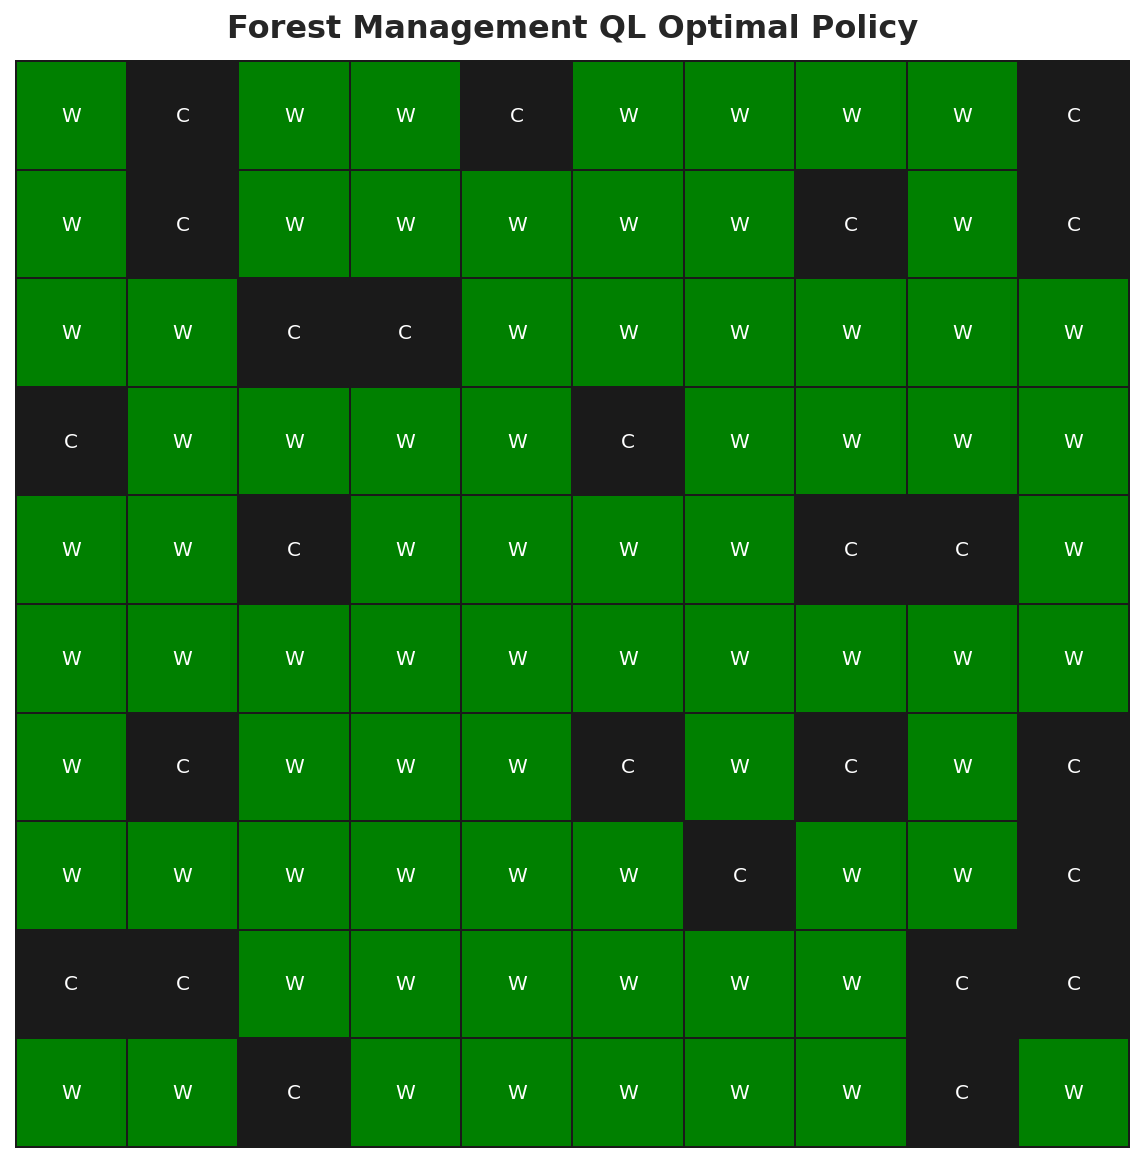

In [53]:
plot_forest_mdp(best_policy, title)

In [55]:
original_env = best_policy.copy()

In [56]:
original_env[original_env > 0] = 0

In [57]:
original_env

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [60]:
colors, labels = {0: 'green',1: 'k'}, {0: '▲',1: 'C'}

def plot_forest_original(policy, title='Forest Management'):
    rows,cols = 10,10
    policy = np.array(list(policy)).reshape(rows,cols)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, xlim=(-.01, cols+0.01), ylim = (-.01, rows+0.01))
    plt.title(title, fontsize=14, y=1.01)
    
    for i in range(10):
        for j in range(10):
            y, x = 10 - i - 1, j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[policy[i,j]])
            ax.add_patch(p)
            
            text = ax.text(x+0.3, y+0.3, labels[policy[i, j]],
                           horizontalalignment='center', size=10, verticalalignment='center', color='w')

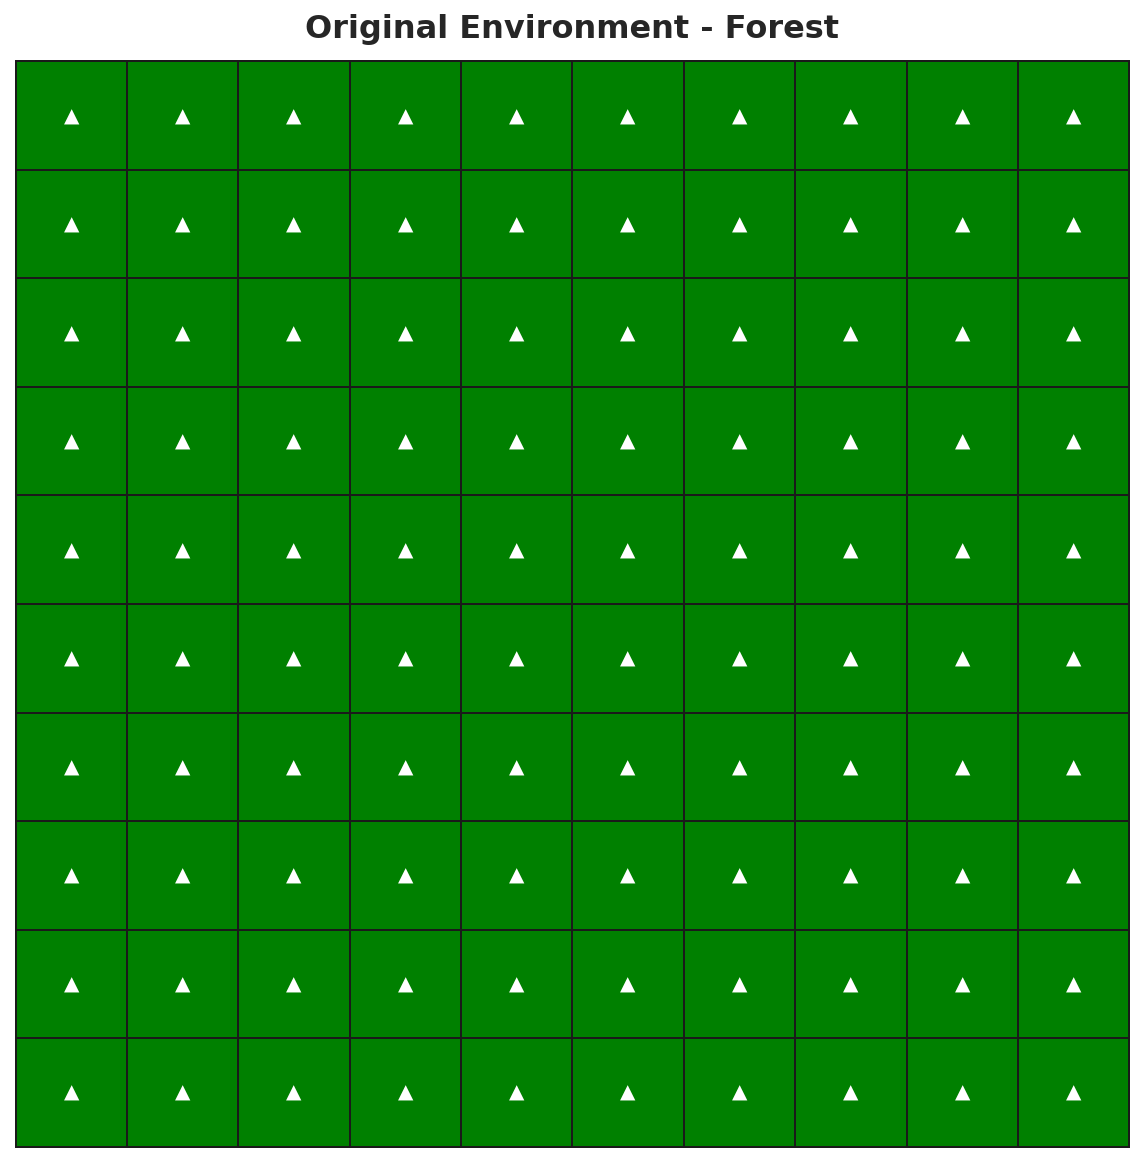

In [62]:
plot_forest_original(original_env,'Original Environment - Forest')

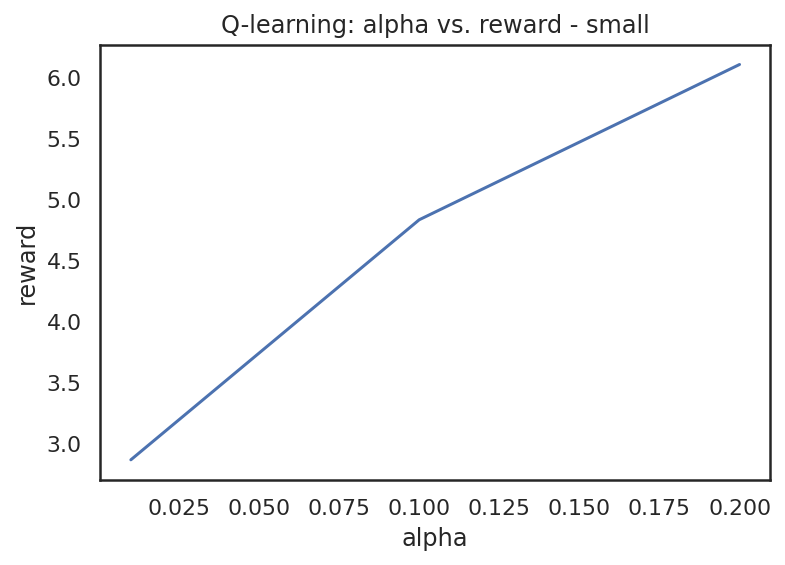

In [64]:
ql_res.groupby('alpha')['reward'].mean().plot()
plt.title('Q-learning: alpha vs. reward - small')
plt.ylabel('reward');

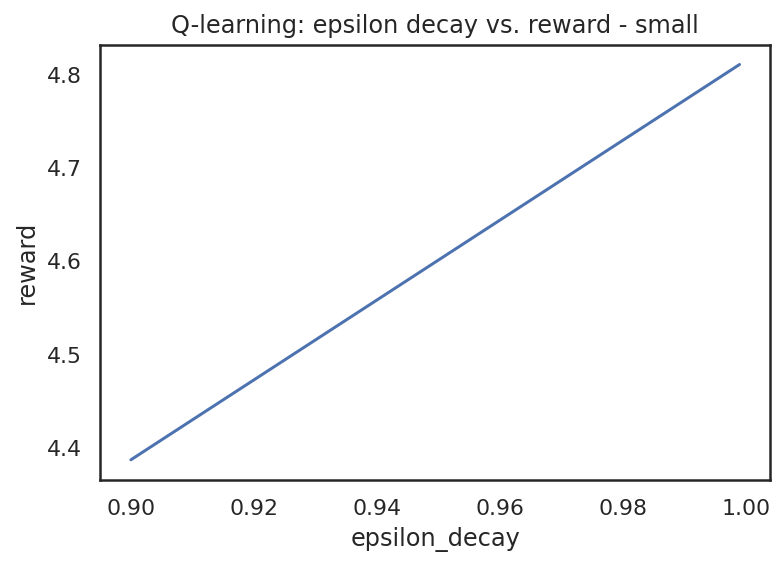

In [65]:
ql_res.groupby('epsilon_decay')['reward'].mean().plot()
plt.title('Q-learning: epsilon decay vs. reward - small')
plt.ylabel('reward');

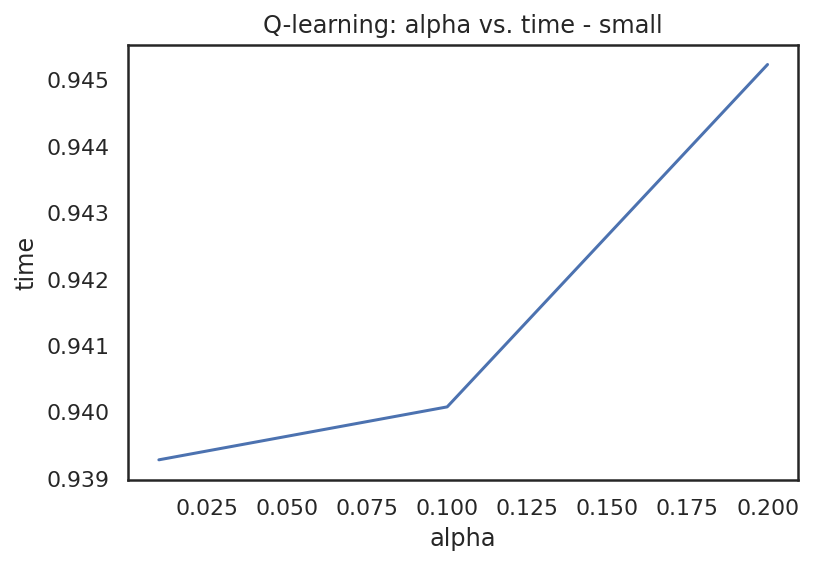

In [66]:
ql_res.groupby('alpha')['time'].mean().plot()
plt.title('Q-learning: alpha vs. time - small')
plt.ylabel('time');

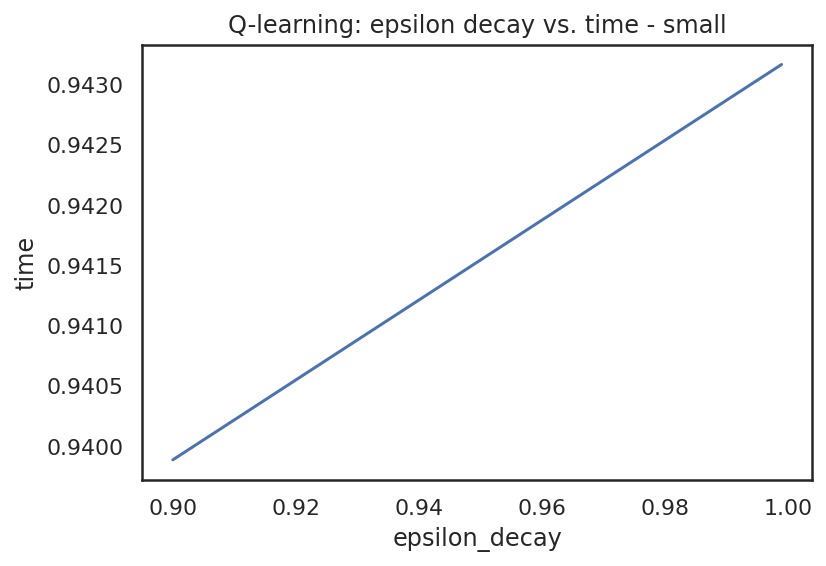

In [67]:
ql_res.groupby('epsilon_decay')['time'].mean().plot()
plt.title('Q-learning: epsilon decay vs. time - small')
plt.ylabel('time');

Text(0, 0.5, 'error')

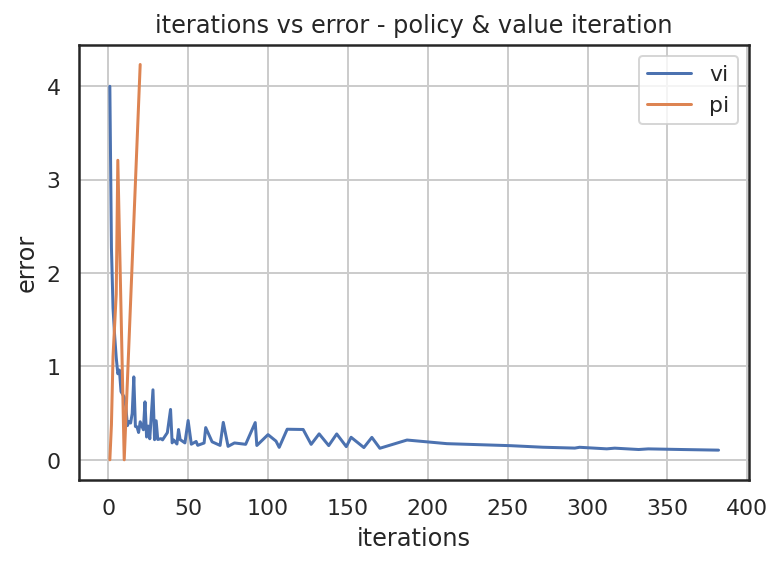

In [135]:
vi_res.groupby('iterations')['error'].mean().plot(label='vi')
pi_res.groupby('iterations')['error'].mean().plot(label='pi')

plt.legend()
plt.grid()
plt.title('iterations vs error - policy & value iteration')
plt.ylabel('error')

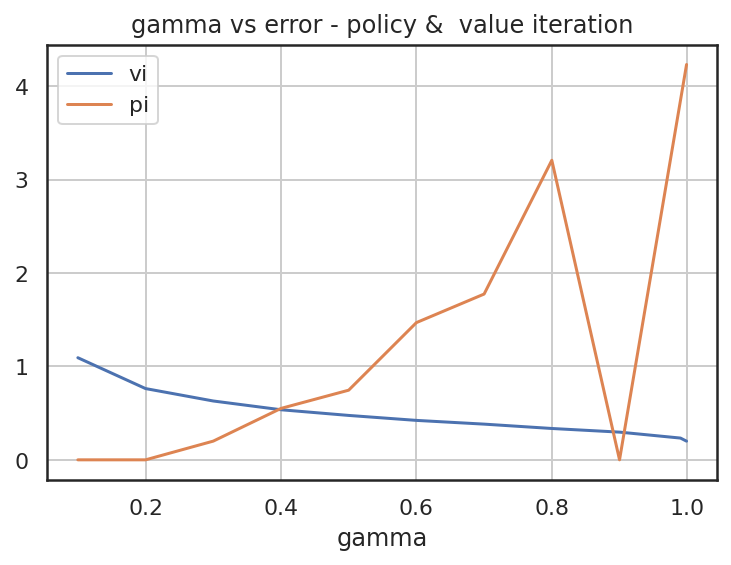

In [134]:
vi_res.groupby('gamma')['error'].mean().plot(label='vi')
pi_res.groupby('gamma')['error'].mean().plot(label='pi')

plt.legend()
plt.grid()
plt.title('gamma vs error - policy &  value iteration')
plt.ylabel('');

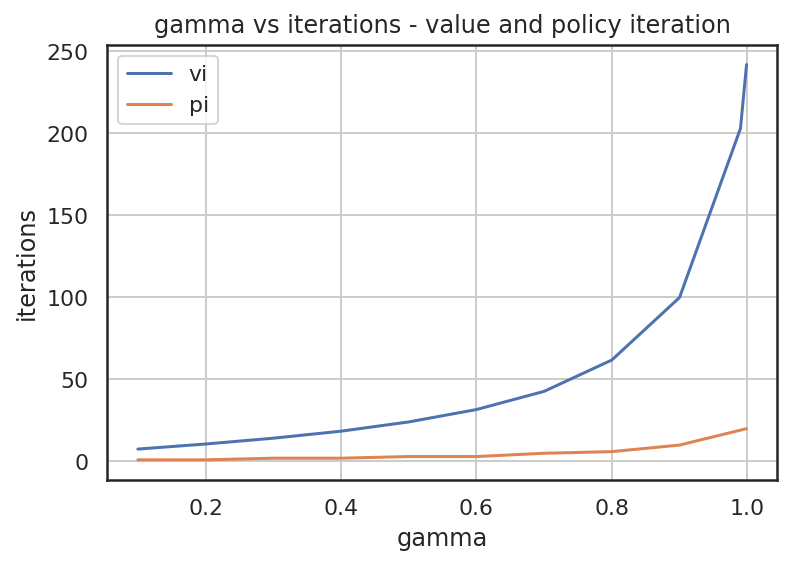

In [137]:
vi_res.groupby('gamma')['iterations'].mean().plot(label='vi')
pi_res.groupby('gamma')['iterations'].mean().plot(label='pi')

plt.legend()
plt.grid()
plt.title('gamma vs iterations - value and policy iteration')
plt.ylabel('iterations');

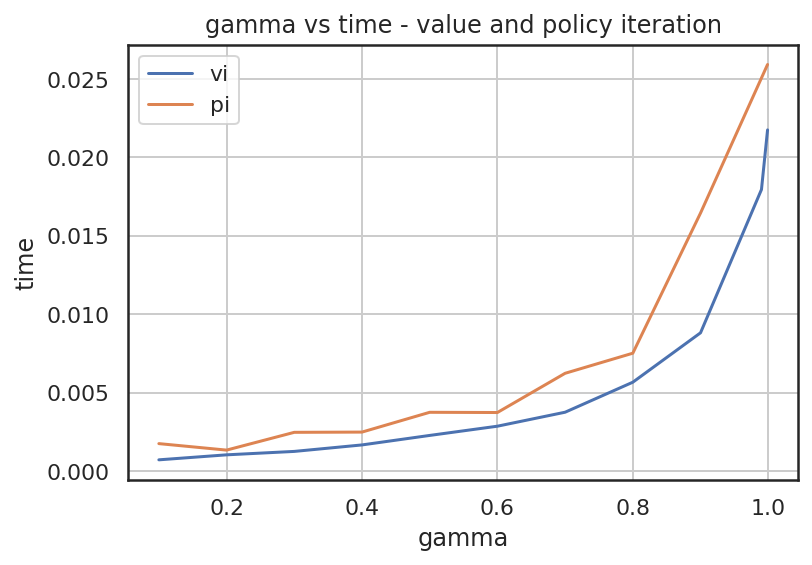

In [124]:
vi_res.groupby('gamma')['time'].mean().plot(label='vi')
pi_res.groupby('gamma')['time'].mean().plot(label='pi')

plt.legend()
plt.grid()
plt.title('gamma vs time - value and policy iteration')
plt.ylabel('time');

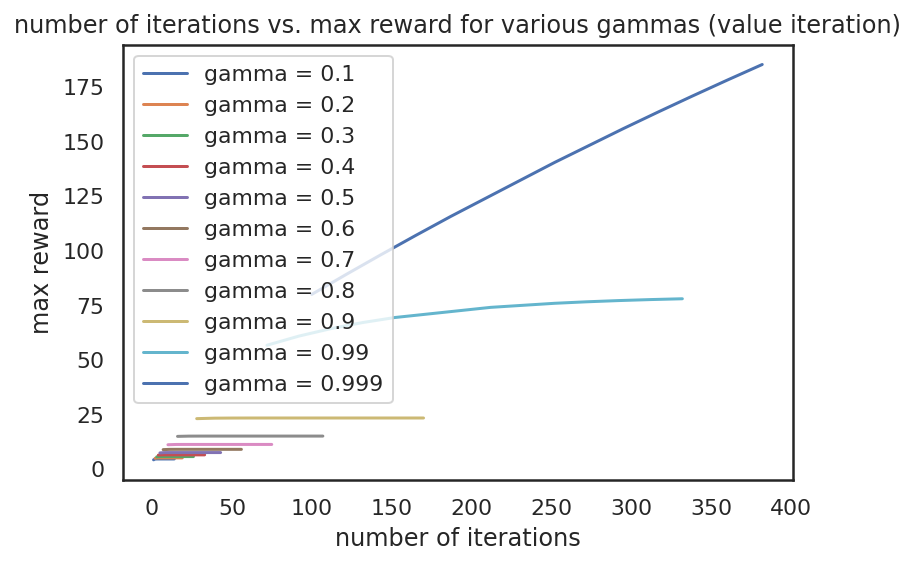

In [138]:
fig, ax = plt.subplots(figsize=(6,4))
for key, grp in vi_res.groupby('gamma')[['reward','iterations']]:
    ax.plot(grp['iterations'], grp['reward'], label='gamma = '+str(key))

ax.legend()
plt.ylabel('max reward')
plt.xlabel('number of iterations')
plt.title('number of iterations vs. max reward for various gammas (value iteration)')
plt.show()